<a href="https://colab.research.google.com/github/Suma-Marri/MBTI-Prediction/blob/main/MBTI_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Myers Briggs Type Indicator (or MBTI) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

Introversion (I) – Extroversion (E)

Intuition (N) – Sensing (S)

Thinking (T) – Feeling (F)

Judging (J) – Perceiving (P)


So for example, someone who prefers introversion, intuition, thinking and perceiving would be labelled an INTP in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

From scientific or psychological perspective it is based on the work done on cognitive functions by Carl Jung i.e. Jungian Typology. This was a model of 8 distinct functions, thought processes or ways of thinking that were suggested to be present in the mind. Later this work was transformed into several different personality systems to make it more accessible, the most popular of which is of course the MBTI.

This dataset contains over 8600 rows of data, on each row is a person’s:

- Type (This persons 4 letter MBTI code/type)
- A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

## Importing all the necessary libraries

In [1]:
!pip install google.colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import re
import string
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import nltk
nltk.download('omw-1.4')

from gensim.models import Word2Vec
from tqdm import tqdm
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn import preprocessing

import tweepy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sb
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

!pip install catboost
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
df = pd.read_csv("/content/drive/MyDrive/mbti_1.csv")
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### Checking for the null values

In [5]:
df.isnull().any()

type     False
posts    False
dtype: bool

In [6]:
df.shape

(8675, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [8]:
types = np.unique(np.array(df['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


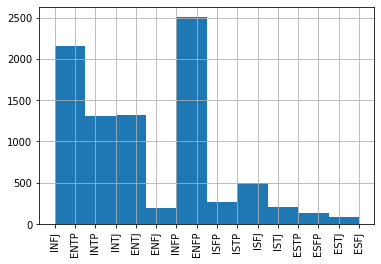

In [9]:
print(df.type.value_counts())
df.type.hist(xrot=90)
plt.show()

### Distribution of different personality types based on their frequencies in the dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


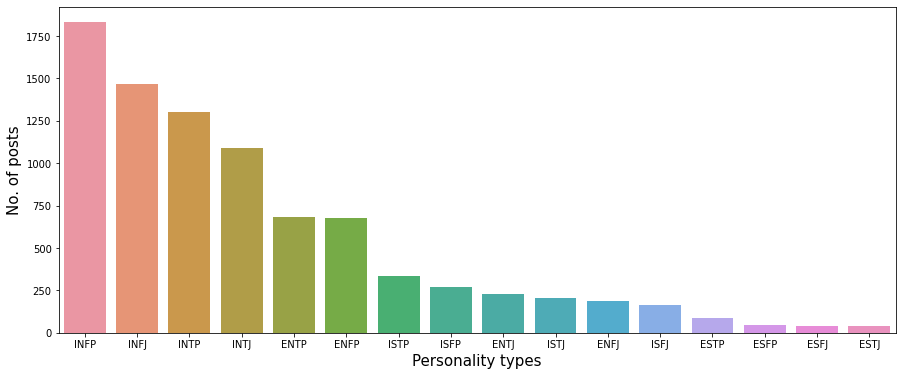

In [10]:
graph = df['type'].value_counts()
plt.figure(figsize=(15,6))
sb.barplot(graph.index, graph.values, alpha=1)
plt.xlabel('Personality types', fontsize=15)
plt.ylabel('No. of posts', fontsize=15)
plt.show()

-> Above plot shows INFP type personalities are most common in our dataset, while ESTJ are least

-> Now analysis based on each user's pattern of tweets is performed

In [11]:
df1 = df.copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 64.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 39.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 60.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/pyth

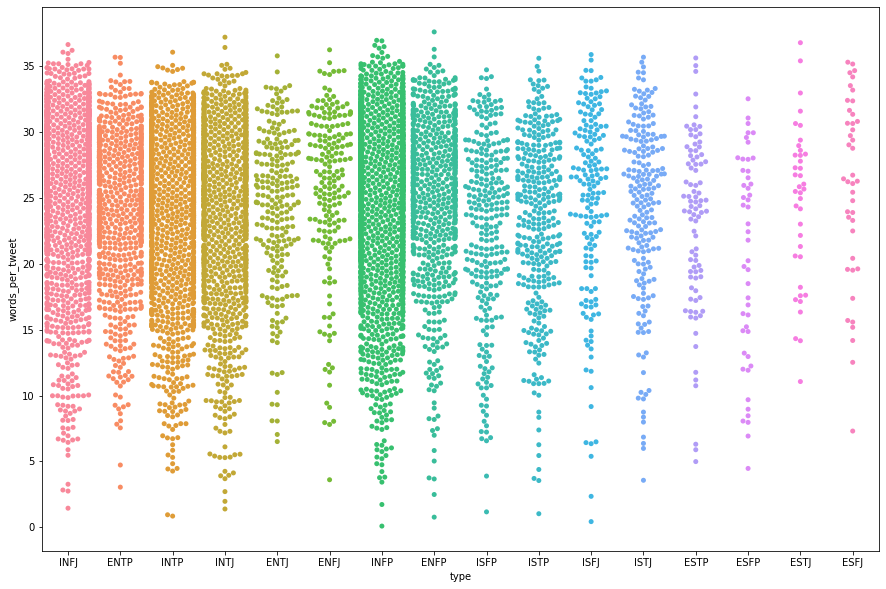

In [12]:
# Swarm Plot
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df1['words_per_tweet'] = df1['posts'].apply(lambda x: len(x.split())/50)
df1['variance_of_word_counts'] = df1['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(15,10))
sb.swarmplot("type", "words_per_tweet", data=df1)

In [13]:
df1.head()

,type,posts,words_per_tweet,variance_of_word_counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576


-> Now wordcloud based on 40 most common words in all posts is generated

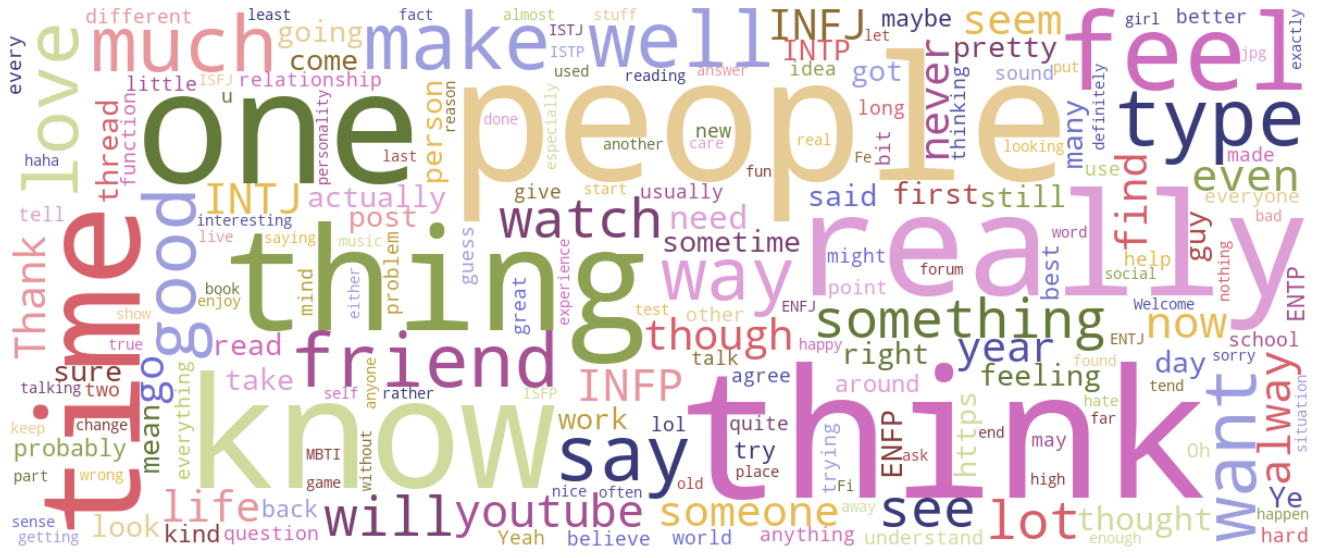

In [14]:
#Plotting WordCloud.

#Finding the most common words in all posts.
words = list(df1["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

-> 5 most common words from above figure are:-
- people
- think
- one
- know
- really

-> Now subplots of wordcloud corresponding to most frequent words in each of the 16 different personalities are generated

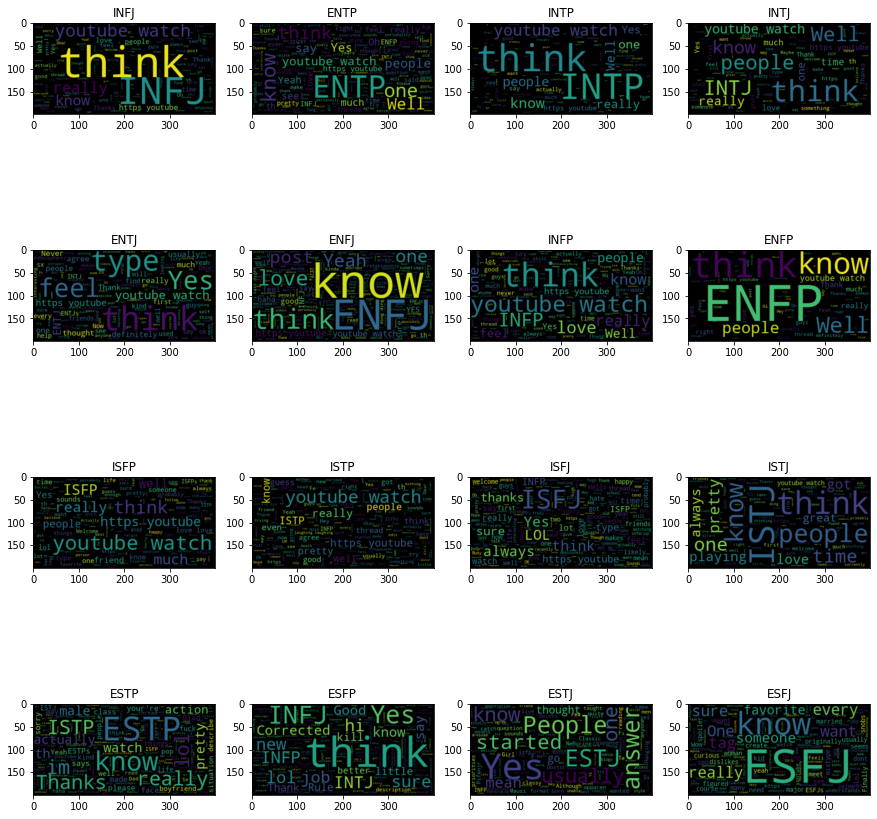

In [15]:
fig, ax = plt.subplots(len(df1['type'].unique()), sharex=True, figsize=(15,len(df1['type'].unique())))
k = 0
for i in df1['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    ax[k].axis("off")
    k+=1

### -> Adding one column for each MBTI characteristic pair, since we will be training independent classifier model for each pair independently. The reason for this is because of imbalance present in our dataset as seen in the EDA section.

In [16]:
df['ie'] = df.type
df['ns'] = df.type
df['ft'] = df.type
df['pj'] = df.type

for i, t in enumerate(df.type):
    if 'I' in t:
        df.ie[i] = 'I'
    elif 'E' in t:
        df.ie[i] = 'E'
        
    if 'N' in t:
        df.ns[i] = 'N'
    elif 'S' in t:
        df.ns[i] = 'S'
        
    if 'F' in t:
        df.ft[i] = 'F'
    elif 'T' in t:
        df.ft[i] = 'T'
        
    if 'P' in t:
        df.pj[i] = 'P'
    elif 'J' in t:
        df.pj[i] = 'J'


posts = df.posts.values
yIE = df.ie.values
yNS = df.ns.values
yFT = df.ft.values
yPJ = df.pj.values
y = df.type

In [17]:
posts.shape

(8675,)

In [18]:
df.head()

,type,posts,ie,ns,ft,pj
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


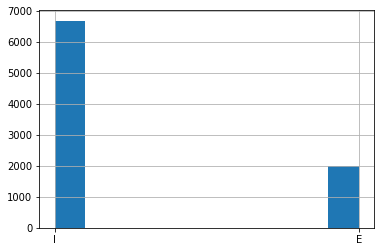

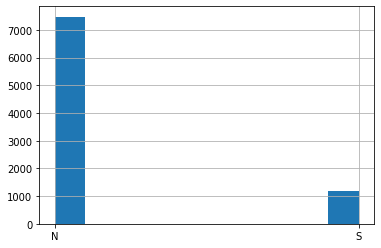

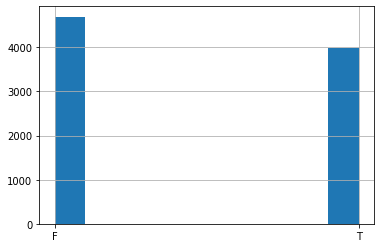

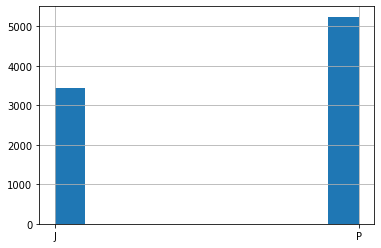

In [19]:
df.ie.hist(); plt.show()
df.ns.hist(); plt.show()
df.ft.hist(); plt.show()
df.pj.hist(); plt.show()

-> Above we can see that there is great unbalance in Introvert/Extrovert and Intuition/Sensing pairs. Whereas Feeling/Thinking and Perception/Judgment pairs are quite balanced.

How many Introvert posts are present v/s how many Extrovert posts are presnt, out of all the given entries in our labelled Kaggle dataset. This is done in order to explore the dataset for all the individual Personality Indices of MBTI

Counting No. of posts in one class / Total no. of posts in the other class

In [20]:
print ("Introversion (I) /  Extroversion (E):\t", df['ie'].value_counts()['I'], " / ", df['ie'].value_counts()['E'])
print ("Intuition (N) / Sensing (S):\t\t", df['ns'].value_counts()['N'], " / ", df['ns'].value_counts()['S'])
print ("Thinking (T) / Feeling (F):\t\t", df['ft'].value_counts()['F'], " / ", df['ft'].value_counts()['T'])
print ("Judging (J) / Perceiving (P):\t\t", df['pj'].value_counts()['P'], " / ", df['pj'].value_counts()['J'])

Introversion (I) /  Extroversion (E):	 6676  /  1999
Intuition (N) / Sensing (S):		 7478  /  1197
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434


### -> Now data preprocessing is performed using regular expressions

In [21]:
#regular expressions for tokenization
regexes = [
    #urls
    #r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',
    
    #html
    #r'<[^>]+>',
    
    #punctuation
    r'(?:(\w+)\'s)',
    
    r'(?:\s(\w+)\.+\s)',
    r'(?:\s(\w+),+\s)',
    r'(?:\s(\w+)\?+\s)',
    r'(?:\s(\w+)!+\s)',
    
    r'(?:\'+(\w+)\'+)',
    r'(?:"+(\w+)"+)',
    r'(?:\[+(\w+)\]+)',
    r'(?:{+(\w+)}+)',
    r'(?:\(+(\w+))',
    r'(?:(\w+)\)+)',

    #words containing numbers & special characters & punctuation
    r'(?:(?:(?:[a-zA-Z])*(?:[0-9!"#$%&\'()*+,\-./:;<=>?@\[\\\]^_`{|}~])+(?:[a-zA-Z])*)+)',
    
    #pure words
    r'([a-zA-Z]+)',
    
    #numbers
    #r'(?:(?:\d+,?)+(?:\.?\d+)?)',

    #emoticons
    #r"""(?:[:=;][oO\-]?[D\)\]\(\]/\\OpP])""",

    #other words
    #r'(?:[\w_]+)',

    #anything else
    #r'(?:\S)'
]

#compiling regular expression
regex = re.compile(r'(?:'+'|'.join(regexes)+')', re.VERBOSE | re.IGNORECASE)

-> Functions like tokenization, lemmatization and stopwords removal is performed

In [22]:

def preprocess(documents):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    #fetching list of stopwords
    punctuation = list(string.punctuation)
    swords = stopwords.words('english') + ['amp'] + ['infp', 'infj', 'intp', 'intj', 'isfp', 'isfj', 'enfp', 'enfj', 'entp', 'entj', 'esfp', 'esfj', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'january', 'feburary', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',  'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',  'jan', 'feb', 'mar', 'apr', 'may', 'jun' 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'tommorow', 'today', 'yesterday'] + ['mr', 'mrs']


    processed_documents = []
    for i,document in enumerate(documents):
        print('{0}/{1}'.format(i+1, len(documents)))
        
        #tokenization
        tokens = regex.findall(document)

        #skipping useless tokens
        t_regex = re.compile(r"[^a-zA-Z]")
        document = []
        
        for token in tokens:
            token = np.array(token)
            token = np.unique(token[token != ''])
            
            if len(token) > 0:
                token = token[0].lower()
            else:
                continue
                
            if re.search(t_regex, token) == None and token not in swords:
                token = lemmatizer.lemmatize(token)
                document.append(token)
                
        document = ' '.join(document)

        #skipping
        if len(document) >= 0:
            processed_documents.append(document)

    print()
    return np.array(processed_documents)

In [23]:
%%time
posts = preprocess(posts)

Streaming output truncated to the last 5000 lines.
3679/8675
3680/8675
3681/8675
3682/8675
3683/8675
3684/8675
3685/8675
3686/8675
3687/8675
3688/8675
3689/8675
3690/8675
3691/8675
3692/8675
3693/8675
3694/8675
3695/8675
3696/8675
3697/8675
3698/8675
3699/8675
3700/8675
3701/8675
3702/8675
3703/8675
3704/8675
3705/8675
3706/8675
3707/8675
3708/8675
3709/8675
3710/8675
3711/8675
3712/8675
3713/8675
3714/8675
3715/8675
3716/8675
3717/8675
3718/8675
3719/8675
3720/8675
3721/8675
3722/8675
3723/8675
3724/8675
3725/8675
3726/8675
3727/8675
3728/8675
3729/8675
3730/8675
3731/8675
3732/8675
3733/8675
3734/8675
3735/8675
3736/8675
3737/8675
3738/8675
3739/8675
3740/8675
3741/8675
3742/8675
3743/8675
3744/8675
3745/8675
3746/8675
3747/8675
3748/8675
3749/8675
3750/8675
3751/8675
3752/8675
3753/8675
3754/8675
3755/8675
3756/8675
3757/8675
3758/8675
3759/8675
3760/8675
3761/8675
3762/8675
3763/8675
3764/8675
3765/8675
3766/8675
3767/8675
3768/8675
3769/8675
3770/8675
3771/8675
3772/8675
3773/8675

In [24]:
posts[0]

'moment sportscenter top ten play experience repeat perc experience immerse last thing friend posted facebook committing suicide next day rest sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth game wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier come three item determined type whichever type want would likely use given cognitive function whatnot left thing moderation sims indeed video game good one good one somewhat subjective completely promoting death given favorite video game growing current favorite video game appears late someone thought confidence good cherish time solitude revel within inner world whereas time workin enjoy time worry people always around lady complimentary main social outlet xbox live conversation even verbally fatigue really dig part thread requires high backyard roast eat marshmellows backyard conversing something intellectual foll

-> Now adding the preprocessed posts back in the dataframe

In [25]:
df['posts'] = posts
df.head(3)

,type,posts,ie,ns,ft,pj
0,INFJ,moment sportscenter top ten play experience re...,I,N,F,J
1,ENTP,finding lack post boring position often exampl...,E,N,T,P
2,INTP,one course say blessing absolutely positive be...,I,N,T,P


## Cleaning and preprocessing of test data

In [26]:
test_df = pd.read_csv("/content/drive/MyDrive/PersonalityPrediction/test_data.csv")
test_df.head()

,type,posts,Unnamed: 2
0,INTJ,Vladimir Putin met with Prime Minister of Arme...,NaN
1,ISTJ,"Welcome aboard, Michael! This year’s grants go...",NaN
2,ESFJ,I thank all those who are committed to allevia...,NaN
3,INTP,"I usually read a lot of non-fiction books, but...",NaN
4,ENTJ,Congratulations to Makhtar Diop on your histor...,NaN


### Visualizations on Test Data

In [28]:
test_df_male = test_df.iloc[:17,:]
test_df_female = test_df.iloc[18:,:]

In [30]:
test_df_male.head()

,type,posts,Unnamed: 2
0,INTJ,Vladimir Putin met with Prime Minister of Arme...,NaN
1,ISTJ,"Welcome aboard, Michael! This year’s grants go...",NaN
2,ESFJ,I thank all those who are committed to allevia...,NaN
3,INTP,"I usually read a lot of non-fiction books, but...",NaN
4,ENTJ,Congratulations to Makhtar Diop on your histor...,NaN


In [31]:
test_df_female.head()

,type,posts,Unnamed: 2
18,ENFJ,Congratulations to Makhtar Diop on your histor...,NaN
19,ESTJ,Happy Hanukkah! Sending my warmest wishes to t...,NaN
20,ENTJ,Grazie mille @fabfazio per l’ospitalità e l’in...,NaN
21,ENTJ,"Factory ZERO, @GM’s first fully dedicated #EV ...",NaN
22,ISTJ,The EU &amp; its Member States will work hard ...,NaN


Males

INTJ    5
ISTJ    4
ESFJ    3
ENTJ    2
INTP    1
INFP    1
ISTP    1
Name: type, dtype: int64


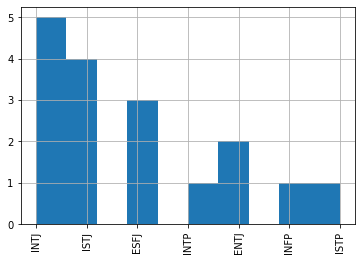

In [32]:
print(test_df_male.type.value_counts())
test_df_male.type.hist(xrot=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


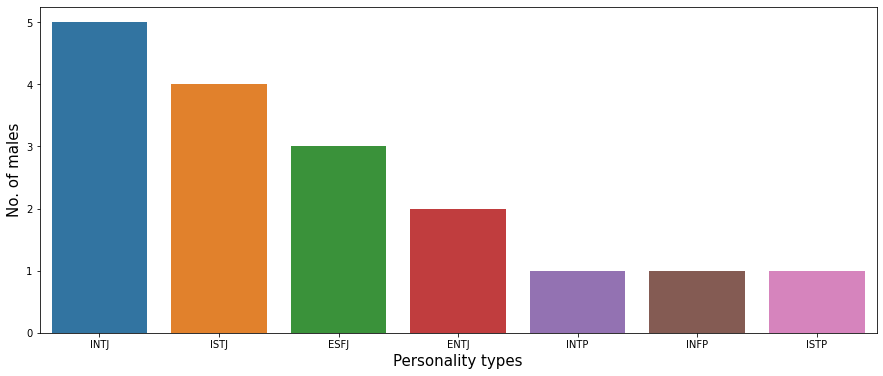

In [33]:
graph = test_df_male['type'].value_counts()
plt.figure(figsize=(15,6))
sb.barplot(graph.index, graph.values, alpha=1)
plt.xlabel('Personality types', fontsize=15)
plt.ylabel('No. of males', fontsize=15)
plt.show()

Females

ENTJ    6
ENFJ    5
ISTJ    2
ESFJ    2
ESTJ    1
INTJ    1
ENFP    1
ISFP    1
Name: type, dtype: int64


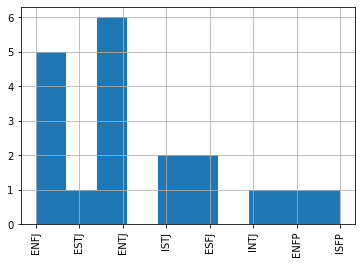

In [34]:
print(test_df_female.type.value_counts())
test_df_female.type.hist(xrot=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


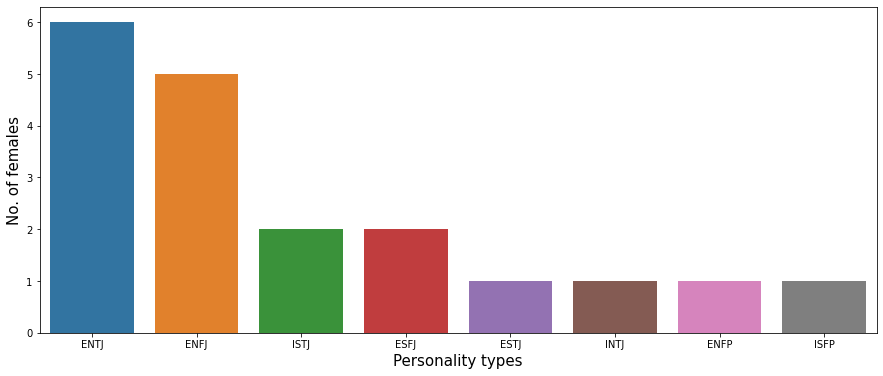

In [35]:
graph = test_df_female['type'].value_counts()
plt.figure(figsize=(15,6))
sb.barplot(graph.index, graph.values, alpha=1)
plt.xlabel('Personality types', fontsize=15)
plt.ylabel('No. of females', fontsize=15)
plt.show()

### Preprocessing on Test Data

In [36]:
test_df['ie'] = test_df.type
test_df['ns'] = test_df.type
test_df['ft'] = test_df.type
test_df['pj'] = test_df.type

for i, t in enumerate(test_df.type):
    if 'I' in t:
        test_df.ie[i] = 'I'
    elif 'E' in t:
        test_df.ie[i] = 'E'
        
    if 'N' in t:
        test_df.ns[i] = 'N'
    elif 'S' in t:
        test_df.ns[i] = 'S'
        
    if 'F' in t:
        test_df.ft[i] = 'F'
    elif 'T' in t:
        test_df.ft[i] = 'T'
        
    if 'P' in t:
        test_df.pj[i] = 'P'
    elif 'J' in t:
        test_df.pj[i] = 'J'


t_posts = test_df.posts.values
t_yIE = test_df.ie.values
t_yNS = test_df.ns.values
t_yFT = test_df.ft.values
t_yPJ = test_df.pj.values
t_y = test_df.type

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A 

In [37]:
%%time
test_posts = test_df['posts']
test_posts = preprocess(test_posts)

1/37
2/37
3/37
4/37
5/37
6/37
7/37
8/37
9/37
10/37
11/37
12/37
13/37
14/37
15/37
16/37
17/37
18/37
19/37
20/37
21/37
22/37
23/37
24/37
25/37
26/37
27/37
28/37
29/37
30/37
31/37
32/37
33/37
34/37
35/37
36/37
37/37

CPU times: user 1.4 s, sys: 235 ms, total: 1.64 s
Wall time: 1.43 s


In [38]:
test_posts[0]

'vladimir putin met prime minister armenia nikol pashinyan sochi leader russia azerbaijan armenia following trilateral talk ilham aliyev nikol pashinyan meeting president azerbaijan ilham aliyev vladimir putin visit india participant guest ceremony conclude year scientific technical innovative cooperation talk president serbia aleksandar vucic conversation european council president charles migration crisis belarusian border conflict government member vladimir putin talk president serbia aleksandar vucic arabia host meeting russia islamic world strategic vision group greeting president vladimir putin meet president azerbaijan ilham aliyev prime minister armenia nikol pashinyan vladimir putin met president palestine mahmoud abbas top agenda middle east macedonia declared mourning life lost bulgarian crash vladimir putin expressed condolence president stevo pendarovski conversation prime minister italy mario gas supply europe development ukraine migration crisis head federal taxation ser

In [39]:
test_df['posts'] = test_posts
test_df.head()

,type,posts,Unnamed: 2,ie,ns,ft,pj
0,INTJ,vladimir putin met prime minister armenia niko...,NaN,I,N,T,J
1,ISTJ,welcome aboard year grant go group led expert ...,NaN,I,S,T,J
2,ESFJ,thank committed alleviating suffering let u re...,NaN,E,S,F,J
3,INTP,usually read lot book lately found drawn back ...,NaN,I,N,T,P
4,ENTJ,congratulation makhtar diop historic appointme...,NaN,E,N,T,J


### Preprocessing using tf-idf

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

In [40]:
%%time

#TF-IDF representation
# creating document frequency matrix
cv = CountVectorizer(analyzer="word", max_features=150).fit(posts)
X = cv.transform(posts)

CPU times: user 5.33 s, sys: 1.21 ms, total: 5.33 s
Wall time: 5.33 s


In [41]:
tf = TfidfTransformer()
X_tf=  tf.fit_transform(X).toarray()

In [42]:
posts.shape, X.shape, X_tf.shape, yIE.shape, yNS.shape # verifying that the shapes match

((8675,), (8675, 150), (8675, 150), (8675,), (8675,))

In [43]:
%%time

#TF-IDF representation
# creating document frequency matrix
cv = CountVectorizer(analyzer="word", max_features=150).fit(test_posts)
X_test_cnt = cv.transform(test_posts)

CPU times: user 41.2 ms, sys: 0 ns, total: 41.2 ms
Wall time: 39.9 ms


In [44]:
X_test_tf=  tf.fit_transform(X_test_cnt).toarray()

In [45]:
t_posts.shape, X_test_cnt.shape, X_test_tf.shape, t_yIE.shape, t_yNS.shape # verifying that the shapes match

((37,), (37, 150), (37, 150), (37,), (37,))

## Training and testing data

In [46]:
xTrain = X_tf
yTrain = y

In [47]:
xTest = X_test_tf
yTest = t_y

In [48]:
xIETrain = X_tf
yIETrain = yIE

xNSTrain = X_tf
yNSTrain = yNS

xFTTrain = X_tf
yFTTrain = yFT

xPJTrain = X_tf
yPJTrain = yPJ

In [49]:
xIETest = X_test_tf
yIETest = t_yIE

xNSTest = X_test_tf
yNSTest = t_yNS

xFTTest = X_test_tf
yFTTest = t_yFT

xPJTest = X_test_tf
yPJTest = t_yPJ

## Label Encoding

In [50]:
frames = [df, test_df]
result = pd.concat(frames)

In [51]:

le = preprocessing.LabelEncoder()
result['type'] = le.fit_transform(result.type.values)

In [52]:
result.ie= le.fit_transform(result.ie.values)
result.ns= le.fit_transform(result.ns.values)
result.ft= le.fit_transform(result.ft.values)
result.pj= le.fit_transform(result.pj.values)

In [53]:
result.head(4)

,type,posts,ie,ns,ft,pj,Unnamed: 2
0,8,moment sportscenter top ten play experience re...,1,0,0,0,NaN
1,3,finding lack post boring position often exampl...,0,0,1,1,NaN
2,11,one course say blessing absolutely positive be...,1,0,1,1,NaN
3,10,enjoyed conversation day esoteric gabbing natu...,1,0,1,0,NaN


In [54]:
df_1 = result.iloc[:8675,:]
df_2 = result.iloc[8675:,:]

Label encoding type column of train data

Label encoding type column of test data

In [55]:
nyTrain = df_1['type']
nyTest = df_2['type']

label encoding ie, ns, ft, pj column of train data


In [56]:
yIE = df_1.ie
yNS = df_1.ns
yFT = df_1.ft
yPJ = df_1.pj

label encoding ie, ns, ft, pj column of test data


In [57]:
t_yIE = df_2.ie
t_yNS = df_2.ns
t_yFT = df_2.ft
t_yPJ = df_2.pj

#**1. Multinomial NB**

In [58]:
model = MultinomialNB().fit(xTrain, nyTrain)
ieModel = MultinomialNB().fit(xIETrain, yIE)
nsModel = MultinomialNB().fit(xNSTrain, yNS)
ftModel = MultinomialNB().fit(xFTTrain, yFT)
pjModel = MultinomialNB().fit(xPJTrain, yPJ)

In [59]:
model.score(xTrain, nyTrain)

0.2204034582132565

In [60]:
print(model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.02702702702702703
0.43243243243243246
0.5945945945945946
0.32432432432432434
0.13513513513513514


As we can see above the first model which tries to predict at at once performs poorly. But the separate model which predicts i or e, n or s, f or t, p or j does good



To get actual performance of our models, I am using KFold cross validation with k=10 to get actual performance. These values will be pickled along with models, so that these can be used in scripts to allow users to see performance and reliability of each model corresponding to their characteristic pair.

In [61]:
scores = []

scores.append(cross_val_score(estimator=model, cv=10, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=10, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=10, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=10, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=10, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.21798298066854827
0.0036035126448341827

0.7695677132333009
0.00032670269741515243

0.862017444548977
0.0004801584863242166

0.6021894716140725
0.007961289059721382

0.6041499901668447
0.0004005530054096249



In [62]:
scores = []

scores.append(cross_val_score(estimator=model, cv=5, X=xTest, y=nyTest, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTest, y=t_yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTest, y=t_yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTest, y=t_yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTest, y=t_yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.19285714285714284
0.11812739577529448

0.46785714285714286
0.16067459827431418

0.5964285714285714
0.13248026422136722

0.65
0.05601566836199331

0.8642857142857142
0.008748177652797088



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [63]:
print('Train Classification Report \n ',classification_report(nyTrain,model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.00      0.00      0.00       675
           2       0.00      0.00      0.00       231
           3       0.00      0.00      0.00       685
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        89
           8       0.23      0.04      0.07      1470
           9       0.22      0.98      0.36      1832
          10       0.67      0.00      0.01      1091
          11       0.29      0.04      0.07      1304
          12       0.00      0.00      0.00       166
          13       0.00      0.00      0.00       271
          14       0.00      0.00      0.00       205
          15       0.00      0.00      0.00       337

    accuracy                           0.22      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
print('Test Classification Report \n ',classification_report(nyTest,model.predict(xTest)))

Test Classification Report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.03      1.00      0.06         1
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1

    accuracy                           0.03        37
   macro avg       0.00      0.08      0.00        37
weighted avg       0.00      0.03      0.00        37



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

# **2. Logistic Regression**


In [65]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)

In [66]:
model_lg = model_log.fit(xTrain, nyTrain)
ieModel = model_log.fit(xIETrain, yIE)
nsModel = model_log.fit(xNSTrain, yNS)
ftModel = model_log.fit(xFTTrain, yFT)
pjModel = model_log.fit(xPJTrain, yPJ)

In [67]:
model_lg.score(xTrain, nyTrain)

0.07331412103746397

In [68]:
model_lg.score(xTest, nyTest)

0.13513513513513514

In [69]:
scores = []

scores.append(cross_val_score(estimator=model_lg, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.2775792507204611
0.011849112414302124

0.7709510086455331
0.0014397689909852057

0.8620172910662823
0.000587783229232608

0.6978674351585015
0.01120826306391399

0.61671469740634
0.009091294134008245



In [70]:
scores = []

scores.append(cross_val_score(estimator=model_lg, cv=5, X=xTest, y=nyTest, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTest, y=t_yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTest, y=t_yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTest, y=t_yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTest, y=t_yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


0.18928571428571425
0.06546536707079771

0.5678571428571428
0.03976974544878587

0.5928571428571429
0.02624453295839121

0.65
0.05601566836199331

0.8642857142857142
0.008748177652797088



In [71]:
print('Train Classification Report \n ',classification_report(nyTrain,model_lg.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.03      0.22      0.05       190
           1       0.08      0.88      0.15       675
           2       0.00      0.00      0.00       231
           3       0.00      0.00      0.00       685
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00      1470
           9       0.00      0.00      0.00      1832
          10       0.00      0.00      0.00      1091
          11       0.00      0.00      0.00      1304
          12       0.00      0.00      0.00       166
          13       0.00      0.00      0.00       271
          14       0.00      0.00      0.00       205
          15       0.00      0.00      0.00       337

    accuracy                           0.07      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
print('Test Classification Report \n ',classification_report(nyTest,model_lg.predict(xTest)))

Test Classification Report 
                precision    recall  f1-score   support

           0       0.17      0.80      0.29         5
           1       0.07      1.00      0.13         1
           2       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1

    accuracy                           0.14        37
   macro avg       0.02      0.16      0.04        37
weighted avg       0.03      0.14      0.04        37



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **3. Random Forest**

In [73]:
random_forest = RandomForestClassifier(n_estimators=100)

In [74]:
rnd_model =  RandomForestClassifier(n_estimators=100).fit(xTrain, nyTrain)
ieModel =  RandomForestClassifier(n_estimators=100).fit(xIETrain, yIE)
nsModel =  RandomForestClassifier(n_estimators=100).fit(xNSTrain, yNS)
ftModel =  RandomForestClassifier(n_estimators=100).fit(xFTTrain, yFT)
pjModel =  RandomForestClassifier(n_estimators=100).fit(xPJTrain, yPJ)

In [75]:
rnd_model.score(xTrain, nyTrain)

0.9997694524495677

In [76]:
print(rnd_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.0
0.43243243243243246
0.5945945945945946
0.5135135135135135
0.21621621621621623


In [77]:
scores = []

scores.append(cross_val_score(estimator=rnd_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.24461095100864555
0.010053300800191425

0.7696829971181556
0.0002823619300038295

0.8620172910662826
0.0002823619300038295

0.6713544668587896
0.009188701041327785

0.6032276657060518
0.003919308357348723



In [78]:
print('Train Classification Report \n ',classification_report(nyTrain,rnd_model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       1.00      1.00      1.00       190
           1       1.00      1.00      1.00       675
           2       1.00      1.00      1.00       231
           3       1.00      1.00      1.00       685
           4       1.00      1.00      1.00        42
           5       1.00      1.00      1.00        48
           6       1.00      1.00      1.00        39
           7       1.00      1.00      1.00        89
           8       1.00      1.00      1.00      1470
           9       1.00      1.00      1.00      1832
          10       1.00      1.00      1.00      1091
          11       1.00      1.00      1.00      1304
          12       1.00      1.00      1.00       166
          13       1.00      1.00      1.00       271
          14       1.00      1.00      1.00       205
          15       1.00      1.00      1.00       337

    accuracy                           1.00      

#**4. K Nearest Neighbor**

In [79]:
knn = KNeighborsClassifier(n_neighbors = 5)

In [80]:
knn_model =  KNeighborsClassifier(n_neighbors = 5).fit(xTrain, nyTrain)
ieModel = KNeighborsClassifier(n_neighbors = 5).fit(xIETrain, yIE)
nsModel =  KNeighborsClassifier(n_neighbors = 5).fit(xNSTrain, yNS)
ftModel =  KNeighborsClassifier(n_neighbors = 5).fit(xFTTrain, yFT)
pjModel =  KNeighborsClassifier(n_neighbors = 5).fit(xPJTrain, yPJ)

In [81]:
knn_model.score(xTrain, nyTrain)

0.4062247838616715

In [82]:
print(knn_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.0
0.40540540540540543
0.5675675675675675
0.4594594594594595
0.35135135135135137


In [83]:
scores = []

scores.append(cross_val_score(estimator=knn_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.1762536023054755
0.009536423229946479

0.7362536023054755
0.0070834773467376355

0.8477233429394813
0.0020426565010570213

0.5985014409221903
0.0109029736740757

0.5701440922190202
0.005147461339888438



In [84]:
print('Train Classification Report \n ',classification_report(nyTrain,knn_model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.23      0.47      0.31       190
           1       0.27      0.53      0.35       675
           2       0.32      0.26      0.29       231
           3       0.37      0.35      0.36       685
           4       0.18      0.14      0.16        42
           5       0.31      0.10      0.16        48
           6       0.13      0.05      0.07        39
           7       0.20      0.08      0.11        89
           8       0.42      0.57      0.48      1470
           9       0.45      0.61      0.52      1832
          10       0.55      0.25      0.34      1091
          11       0.55      0.33      0.41      1304
          12       0.35      0.07      0.11       166
          13       0.53      0.09      0.15       271
          14       0.38      0.07      0.12       205
          15       0.53      0.14      0.22       337

    accuracy                           0.41      

#**KNN ||**

In [85]:
knn = KNeighborsClassifier(n_neighbors = 3)  

In [86]:
knn_model =  KNeighborsClassifier(n_neighbors = 3).fit(xTrain, nyTrain)
ieModel = KNeighborsClassifier(n_neighbors = 3).fit(xIETrain, yIE)
nsModel =  KNeighborsClassifier(n_neighbors = 3).fit(xNSTrain, yNS)
ftModel =  KNeighborsClassifier(n_neighbors = 3).fit(xFTTrain, yFT)
pjModel =  KNeighborsClassifier(n_neighbors = 3).fit(xPJTrain, yPJ)

In [87]:
knn_model.score(xTrain, nyTrain)

0.46904899135446687

In [88]:
print(knn_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.0
0.32432432432432434
0.5675675675675675
0.5405405405405406
0.3783783783783784


In [89]:
scores = []

scores.append(cross_val_score(estimator=knn_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.15435158501440924
0.010460102683136062

0.7112391930835735
0.00954060251138149

0.8263976945244957
0.0045587826935527724

0.5840922190201729
0.00912484953413871

0.5563112391930836
0.007588832548994952



#**KNN |||**

In [90]:
knn_model =  KNeighborsClassifier(n_neighbors = 2).fit(xTrain, nyTrain)
ieModel = KNeighborsClassifier(n_neighbors = 2).fit(xIETrain, yIE)
nsModel =  KNeighborsClassifier(n_neighbors = 2).fit(xNSTrain, yNS)
ftModel =  KNeighborsClassifier(n_neighbors = 2).fit(xFTTrain, yFT)
pjModel =  KNeighborsClassifier(n_neighbors = 2).fit(xPJTrain, yPJ)

In [91]:
knn_model.score(xTrain, nyTrain)

0.5497406340057637

In [92]:
print(knn_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.0
0.32432432432432434
0.6216216216216216
0.40540540540540543
0.5675675675675675


In [93]:
scores = []

scores.append(cross_val_score(estimator=knn_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.14743515850144093
0.007174808677623253

0.5704899135446685
0.015878517962154663

0.848299711815562
0.003760116756265148

0.5663400576368877
0.015330111968447696

0.49717579250720456
0.004719190660624485



# **5. CatBoost Classifier**

In [94]:
model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU', verbose=False)

In [95]:
cat =  model_cat.fit(xTrain, nyTrain)
ieModel = model_cat.fit(xIETrain, yIE)
nsModel =  model_cat.fit(xNSTrain, yNS)
ftModel =  model_cat.fit(xFTTrain, yFT)
pjModel =  model_cat.fit(xPJTrain, yPJ)

In [96]:
cat.score(xTrain, nyTrain)

0.09959654178674351

In [97]:
print(cat.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.13513513513513514
0.43243243243243246
0.5135135135135135
0.5945945945945946
0.4594594594594595


In [98]:
scores = []

scores.append(cross_val_score(estimator=cat, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.2622478386167147
0.0057866975898610475

0.765763688760807
0.0010049334740151585

0.8612103746397695
0.0018371616657647848

0.6859942363112392
0.010636465590245305

0.6011527377521613
0.005155199948126337



In [99]:
print('Train Classification Report \n ',classification_report(nyTrain,model_cat.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.06      0.99      0.10       190
           1       0.13      1.00      0.23       675
           2       0.00      0.00      0.00       231
           3       0.00      0.00      0.00       685
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        89
           8       0.00      0.00      0.00      1470
           9       0.00      0.00      0.00      1832
          10       0.00      0.00      0.00      1091
          11       0.00      0.00      0.00      1304
          12       0.00      0.00      0.00       166
          13       0.00      0.00      0.00       271
          14       0.00      0.00      0.00       205
          15       0.00      0.00      0.00       337

    accuracy                           0.10      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **6. XGBoost**

In [108]:
xgb = XGBClassifier(objective='binary:logistic', num_class = '2')

In [109]:
xgb_model =  xgb.fit(xTrain, nyTrain)
ieModel = xgb.fit(xIETrain, yIE)
nsModel =  xgb.fit(xNSTrain, yNS)
ftModel =  xgb.fit(xFTTrain, yFT)
pjModel =  xgb.fit(xPJTrain, yPJ)

TypeError: ignored

In [110]:
xgb_model.score(xTrain, nyTrain)

ValueError: ignored

In [ ]:
xgb_model.score(xTest, nyTest)

In [ ]:
scores = []

scores.append(cross_val_score(estimator=xgb_model, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,xgb_model.predict(xTrain)))

In [ ]:
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)

In [ ]:
x_model =  model_xgb.fit(xTrain, nyTrain)
ieModel = model_xgb.fit(xIETrain, yIETrain)
nsModel =  model_xgb.fit(xNSTrain, yNSTrain)
ftModel =  model_xgb.fit(xFTTrain, yFTTrain)
pjModel =  model_xgb.fit(xPJTrain, yPJTrain)

In [ ]:
x_model.score(xTrain, nyTrain)

In [ ]:
print(x_model.score(xTest, nyTest))

In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,x_model.predict(xTrain)))

#**7. Stochastic Gradient Descent (SGD)**

In [111]:
sgd = SGDClassifier(max_iter=5, tol=None)

In [112]:
sgd_model =  sgd.fit(xTrain, nyTrain)
ieModel = sgd.fit(xIETrain, yIE)
nsModel =  sgd.fit(xNSTrain, yNS)
ftModel =  sgd.fit(xFTTrain, yFT)
pjModel =  sgd.fit(xPJTrain, yPJ)

In [113]:
sgd_model.score(xTrain, nyTrain)

0.07711815561959655

In [114]:
print(sgd_model.score(xTest, nyTest))
print(ieModel.score(xIETest, t_yIE))
print(nsModel.score(xNSTest, t_yNS))
print(ftModel.score(xFTTest, t_yFT))
print(pjModel.score(xPJTest, t_yPJ))

0.05405405405405406
0.43243243243243246
0.4594594594594595
0.5945945945945946
0.24324324324324326


In [115]:
scores = []

scores.append(cross_val_score(estimator=sgd_model, cv=5, X=xTrain, y=y, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.2096829971181556
0.03190065053342403

0.7390201729106629
0.05915510512464359

0.8622478386167147
0.00036452768416927203

0.6560230547550432
0.03690273465066635

0.5987319884726225
0.00976362751716875



In [116]:
scores = []

scores.append(cross_val_score(estimator=sgd_model, cv=5, X=xTest, y=nyTest, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTest, y=t_yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTest, y=t_yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTest, y=t_yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTest, y=t_yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.13571428571428573
0.09077332162242023

0.5142857142857142
0.131416924949815

0.5178571428571429
0.07659860924831148

0.6464285714285714
0.0735402152927643

0.8642857142857142
0.008748177652797088



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


#**8. Support vector classification**

In [117]:
svm = SVC(random_state = 1)

In [118]:
svm_model =  svm.fit(xTrain, yTrain)
# ieModel =  svm.fit(xIETrain, yIETrain)
# nsModel =  svm.fit(xNSTrain, yNSTrain)
# ftModel =  svm.fit(xFTTrain, yFTTrain)
# pjModel =  svm.fit(xPJTrain, yPJTrain)

In [119]:
svm_model.score(xTrain, yTrain)

0.5523919308357349

In [120]:
print(svm_model.score(xTest, yTest))
# print(ieModel.score(xIETest, yIETest))
# print(nsModel.score(xNSTest, yNSTest))
# print(ftModel.score(xFTTest, yFTTest))
# print(pjModel.score(xPJTest, yPJTest))

0.05405405405405406


In [121]:
print('Train Classification Report \n ',classification_report(yTrain,svm_model.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       190
        ENFP       0.82      0.24      0.37       675
        ENTJ       1.00      0.03      0.06       231
        ENTP       0.76      0.38      0.50       685
        ESFJ       0.00      0.00      0.00        42
        ESFP       0.00      0.00      0.00        48
        ESTJ       0.00      0.00      0.00        39
        ESTP       0.00      0.00      0.00        89
        INFJ       0.54      0.70      0.61      1470
        INFP       0.49      0.86      0.62      1832
        INTJ       0.62      0.63      0.62      1091
        INTP       0.55      0.76      0.64      1304
        ISFJ       0.00      0.00      0.00       166
        ISFP       1.00      0.05      0.09       271
        ISTJ       1.00      0.02      0.04       205
        ISTP       1.00      0.19      0.32       337

    accuracy                           0.55      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **9. Linear SVC**

In [122]:
yIE = df['ie']
yNS = df['ns']
yFT = df['ft']
yPJ = df['pj']

In [128]:

model_linear_svc=LinearSVC(C=0.1)
lscv =  model_linear_svc.fit(xTrain, nyTrain)
# ieModel = model_linear_svc.fit(xIETrain, yIE)
# nsModel =  model_linear_svc.fit(xNSTrain, yNS)
# ftModel =  model_linear_svc.fit(xFTTrain, yFT)
# pjModel =  model_linear_svc.fit(xPJTrain, yPJ)

In [129]:
print(lscv.score(xTrain, nyTrain))
print(lscv.score(xTest, nyTest))

0.3138904899135447
0.05405405405405406


In [130]:
print(lscv.score(xIETest, t_yIE))
print(lscv.score(xNSTest, t_yNS))
print(lscv.score(xFTTest, t_yFT))
print(lscv.score(xPJTest, t_yPJ))

0.02702702702702703
0.0
0.02702702702702703
0.0


In [132]:
print('Train Classification Report \n ',classification_report(nyTrain,lscv.predict(xTrain)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.29      0.07      0.12       675
           2       0.00      0.00      0.00       231
           3       0.25      0.05      0.08       685
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        48
           6       0.00      0.00      0.00        39
           7       0.00      0.00      0.00        89
           8       0.30      0.32      0.31      1470
           9       0.33      0.71      0.45      1832
          10       0.30      0.26      0.28      1091
          11       0.30      0.45      0.36      1304
          12       0.00      0.00      0.00       166
          13       0.17      0.00      0.01       271
          14       0.00      0.00      0.00       205
          15       0.60      0.03      0.05       337

    accuracy                           0.31      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [133]:
scores = []

# scores.append(cross_val_score(estimator=lscv, cv=5, X=xTrain, y=nyTrain, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTrain, y=yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTrain, y=yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTrain, y=yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTrain, y=yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')

0.7707204610951008
0.0018729771538065507

0.8619020172910663
0.000587783229232608

0.6985590778097983
0.012297070066254344

0.6172910662824207
0.00804442481723015



In [134]:
print('Train Classification Report \n ',classification_report(nyTest,lscv.predict(xTest)))

Train Classification Report 
                precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.18      0.33      0.24         6
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         1

    accuracy                           0.05        37
   macro avg       0.02      0.03      0.02        37
weighted avg       0.03      0.05      0.04        37



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

## Prediction for Karan Johar

In [162]:
KaranJohar_df = pd.read_csv("/content/drive/MyDrive/PersonalityPrediction/karanjohar_tweets.csv")
KaranJohar_df.head()

,id,created_at,favorite_count,retweet_count,text
0,1469849247042334721,2021-12-12 01:59:03,2133,149,(2/2) All of Edwardsville should know that the...
1,1469849245624647681,2021-12-12 01:59:03,4346,319,The news from Edwardsville is tragic. We’re he...
2,1469320158996951043,2021-12-10 14:56:39,3409,226,Loved being with @MichaelStrahan on Thursday N...
3,1469107355530919938,2021-12-10 00:51:02,2187,122,"Congrats again, DJ. No one more deserving than..."
4,1467937061319495681,2021-12-06 19:20:43,2649,236,Today the Washington Post and the world lost a...


In [163]:

pop_df = KaranJohar_df['text']

In [164]:
%%time
pop_posts = pop_df
pop_posts = preprocess(pop_posts)

1/52
2/52
3/52
4/52
5/52
6/52
7/52
8/52
9/52
10/52
11/52
12/52
13/52
14/52
15/52
16/52
17/52
18/52
19/52
20/52
21/52
22/52
23/52
24/52
25/52
26/52
27/52
28/52
29/52
30/52
31/52
32/52
33/52
34/52
35/52
36/52
37/52
38/52
39/52
40/52
41/52
42/52
43/52
44/52
45/52
46/52
47/52
48/52
49/52
50/52
51/52
52/52

CPU times: user 86.3 ms, sys: 24.1 ms, total: 110 ms
Wall time: 92.9 ms


In [165]:
# cv = CountVectorizer(analyzer="word", max_features=1500).fit(jac_posts)
pop_X = cv.transform(pop_posts)
pop_X_tf=  tf.fit_transform(pop_X).toarray()

In [166]:
ieModel = model_linear_svc.fit(xIETrain, yIE)

In [167]:
predicted_ie = ieModel.predict(pop_X_tf)
ieModel.predict(pop_X_tf)

array(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
       'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'],
      dtype=object)

In [168]:
nsModel =  model_linear_svc.fit(xNSTrain, yNS)

In [169]:
predicted_ns = nsModel.predict(pop_X_tf)
nsModel.predict(pop_X_tf)

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N'],
      dtype=object)

In [170]:
ftModel =  model_linear_svc.fit(xFTTrain, yFT)

In [171]:
predicted_ft = ftModel.predict(pop_X_tf)
ftModel.predict(pop_X_tf)

array(['T', 'F', 'F', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T',
       'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'F', 'T',
       'T', 'T', 'T', 'T', 'T', 'T', 'F', 'T', 'T', 'T', 'T', 'T', 'T'],
      dtype=object)

In [172]:
pjModel =  model_linear_svc.fit(xPJTrain, yPJ)

In [173]:
predicted_pj = pjModel.predict(pop_X_tf)
pjModel.predict(pop_X_tf)

array(['P', 'P', 'J', 'P', 'J', 'P', 'P', 'P', 'J', 'J', 'P', 'P', 'P',
       'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'J', 'P', 'P', 'P', 'P', 'P', 'J', 'J', 'J', 'P',
       'P', 'P', 'P', 'P', 'J', 'J', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
      dtype=object)

In [175]:
KaranJohar_df

,id,created_at,favorite_count,retweet_count,text
0,1469849247042334721,2021-12-12 01:59:03,2133,149,(2/2) All of Edwardsville should know that the...
1,1469849245624647681,2021-12-12 01:59:03,4346,319,The news from Edwardsville is tragic. We’re he...
2,1469320158996951043,2021-12-10 14:56:39,3409,226,Loved being with @MichaelStrahan on Thursday N...
3,1469107355530919938,2021-12-10 00:51:02,2187,122,"Congrats again, DJ. No one more deserving than..."
4,1467937061319495681,2021-12-06 19:20:43,2649,236,Today the Washington Post and the world lost a...
5,1463575768697491458,2021-11-24 18:30:29,3671,332,"Welcome aboard, Michael! https://t.co/UfLHValZoT"
6,1460968710965841921,2021-11-17 13:50:58,1308,130,(2/2) This year’s grants go to 32 groups led b...
7,1460968707971112963,2021-11-17 13:50:58,8232,381,"For the fourth year in a row, the Bezos Day 1 ..."
8,1459298556515270657,2021-11-12 23:14:22,2120,97,(2/2) Our deepest sympathies are with his part...
9,1459298553860296709,2021-11-12 23:14:22,7151,442,"Such a tragic loss. Warm and full of life, Gle..."


In [177]:
plt.figure(0)
KaranJohar_df.groupby('predicted_ie')['predicted_ie'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(1)
KaranJohar_df.groupby('predicted_ns')['predicted_ns'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(2)
KaranJohar_df.groupby('predicted_ft')['predicted_ft'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.figure(3)
KaranJohar_df.groupby('predicted_pj')['predicted_pj'].count().plot.pie(autopct='%.2f',figsize=(5,5))

plt.show() #show all figures

TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.style.use('ggplot')

plt.figure(0)
KaranJohar_df.groupby(['id','predicted_ie']).predicted_ie.count().unstack().plot.bar(legend=True)

plt.figure(1)
KaranJohar_df.groupby(['id','predicted_ns']).predicted_ns.count().unstack().plot.bar(legend=True)

plt.figure(2)
KaranJohar_df.groupby(['id','predicted_ft']).predicted_ft.count().unstack().plot.bar(legend=True)

plt.figure(3)
KaranJohar_df.groupby(['id','predicted_pj']).predicted_pj.count().unstack().plot.bar(legend=True)

plt.show() #show all figures

#**10. Decision Tree**

In [ ]:
model_tree=DecisionTreeClassifier(max_depth=14)

In [ ]:
dt =  model_tree.fit(xTrain, nyTrain)
ieModel = model_tree.fit(xIETrain, yIETrain)
nsModel =  model_tree.fit(xNSTrain, yNSTrain)
ftModel =  model_tree.fit(xFTTrain, yFTTrain)
pjModel =  model_tree.fit(xPJTrain, yPJTrain)

In [ ]:
dt.score(xTrain, nyTrain)

In [ ]:
print(dt.score(xTest, nyTest))
print(ieModel.score(xIETest, yIETest))
print(nsModel.score(xNSTest, yNSTest))
print(ftModel.score(xFTTest, yFTTest))
print(pjModel.score(xPJTest, yPJTest))

In [ ]:
print('Train Classification Report \n ',classification_report(nyTrain,dt.predict(xTrain)))

In [ ]:
scores = []

scores.append(cross_val_score(estimator=dt, cv=5, X=xTest, y=t_y, scoring='accuracy'))
scores.append(cross_val_score(estimator=ieModel, cv=5, X=xTest, y=t_yIE, scoring='accuracy'))
scores.append(cross_val_score(estimator=nsModel, cv=5, X=xTest, y=t_yNS, scoring='accuracy'))
scores.append(cross_val_score(estimator=ftModel, cv=5, X=xTest, y=t_yFT, scoring='accuracy'))
scores.append(cross_val_score(estimator=pjModel, cv=5, X=xTest, y=t_yPJ, scoring='accuracy'))

#prining mean and standard deviations for each model
for score in scores:
    print(score.mean())
    print(score.std(), end='\n\n')